# Travel Destination Analysis & Recommendation System

# Import all libraries

In [812]:
import pandas as pd
import matplotlib.pyplot as plt 
import csv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np
import re
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import plotly.express as px

# Load and clean data

In [813]:
csv_path = "../data/destinations_cleaned.csv"
df = pd.read_csv(csv_path, encoding='utf-8')


# Replace missing or empty descriptions

In [814]:
df["Description"] = df["Description"].fillna("").replace(r"^\s*$", "Description not found.", regex=True)
df["Description"] = df["Description"].apply(lambda x: x if isinstance(x, str) else "Description not found.")

# Clean approximate annual tourists column

In [815]:
def parse_tourist_count(value):
    if isinstance(value, (int, float)):
        return value
    if pd.isna(value):
        return None
    s = str(value).lower().strip().replace(',', '')
    if "million" in s:
        s = s.replace("million", "").strip()
        if '-' in s:
            parts = s.split('-')
            try:
                nums = [float(part.strip()) for part in parts if part.strip()]
                return sum(nums) / len(nums)
            except ValueError:
                return None
        else:
            try:
                return float(s)
            except ValueError:
                return None
    else:
        if '-' in s:
            parts = s.split('-')
            try:
                nums = [float(part.strip()) for part in parts if part.strip()]
                raw = sum(nums) / len(nums)
            except ValueError:
                return None
        else:
            try:
                raw = float(s)
            except ValueError:
                return None
        return raw / 1e6

if "Approximate Annual Tourists" in df.columns:
    df["Approximate Annual Tourists(million)"] = df["Approximate Annual Tourists"].apply(parse_tourist_count)

# EDA: Tourist Distribution by Country

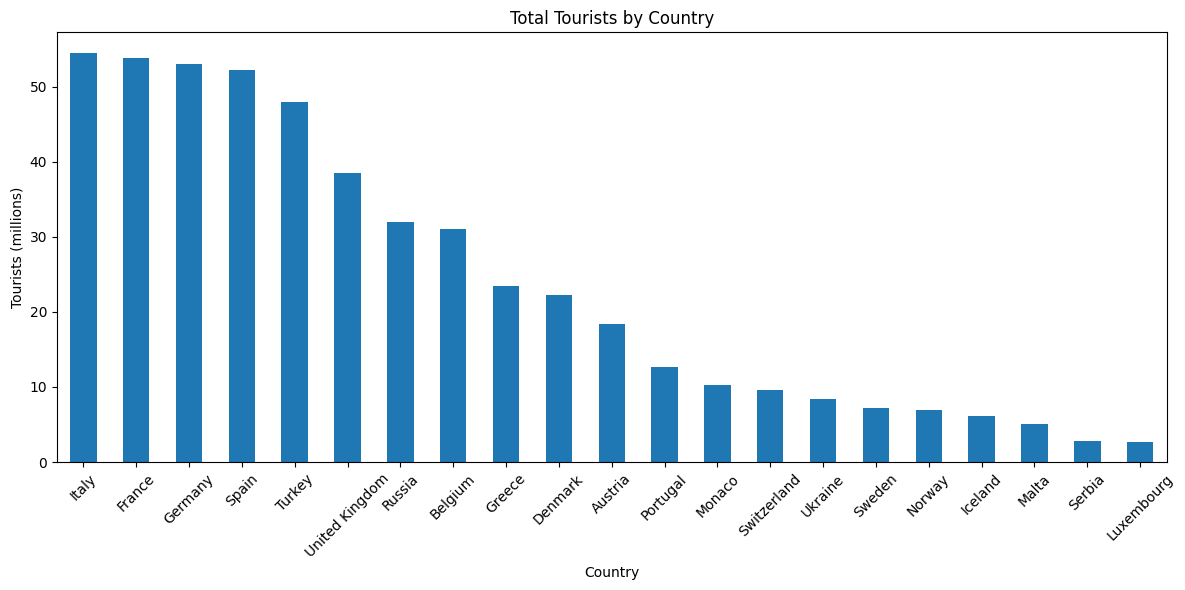

In [816]:
plt.figure(figsize=(12, 6))
country_counts = df.groupby("Country")["Approximate Annual Tourists(million)"].sum().sort_values(ascending=False)
country_counts.plot(kind='bar')
plt.title("Total Tourists by Country")
plt.ylabel("Tourists (millions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# EDA: Count of Destinations per Category

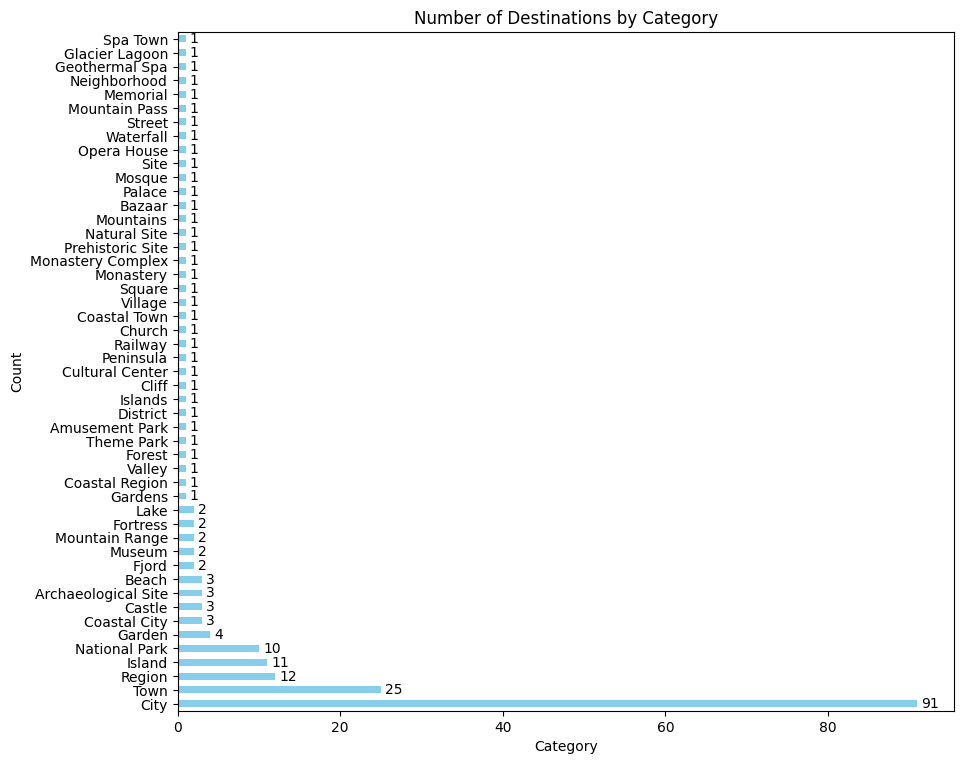

In [817]:
category_counts = df["Category"].value_counts().sort_values(ascending = False)

plt.figure(figsize=(10, 8))
category_counts.plot(kind="barh", color="skyblue")
plt.title("Number of Destinations by Category")
plt.xlabel("Category")
plt.ylabel("Count")
for index, value in enumerate(category_counts):
    plt.text(value + .5, index, str(int(value)), va = 'center')
plt.yticks(ticks=range(len(category_counts)), labels=category_counts.index, fontsize=10)
plt.tight_layout(pad = 2.0)
plt.show()

# Broad Category Mapping </br>
From the graph above, there are too many different categories than I previously anticipated, I am grouping them into broader categories.

In [818]:
category_map = {
    # Wellness & Relaxation
    "Spa Town": "Wellness",
    "Geothermal Spa": "Wellness",

    # Nature
    "Glacier Lagoon": "Nature",
    "Natural Site": "Nature",
    "Waterfall": "Nature",
    "Mountain Pass": "Nature",
    "Cliff": "Nature",
    "Valley": "Nature",
    "Lake": "Nature",
    "Fjord": "Nature",
    "Forest": "Nature",
    "Mountain Range": "Nature",
    "Mountains": "Nature",
    "Island": "Nature",
    "Islands": "Nature",
    "Peninsula": "Nature",
    "National Park": "Nature",
    "Gardens": "Nature",
    "Garden": "Nature",

    # Urban / Human Settlements
    "City": "Urban",
    "Town": "Urban",
    "Village": "Urban",
    "Region": "Urban",
    "District": "Urban",
    "Neighborhood": "Urban",
    "Coastal Town": "Urban",
    "Coastal Region": "Urban",
    "Coastal City": "Urban",
    "Square": "Urban",
    "Street": "Urban",

    # History & Culture
    "Prehistoric Site": "History & Culture",
    "Memorial": "History & Culture",
    "Monastery": "History & Culture",
    "Monastery Complex": "History & Culture",
    "Mosque": "History & Culture",
    "Church": "History & Culture",
    "Cultural Center": "History & Culture",
    "Palace": "History & Culture",
    "Bazaar": "History & Culture",
    "Opera House": "History & Culture",
    "Fortress": "History & Culture",
    "Castle": "History & Culture",
    "Archaeological Site": "History & Culture",
    "UNESCO Site": "History & Culture",
    "Site": "History & Culture",  # Only 1 entry: Chernobyl Exclusion Zone

    # Museums & Arts
    "Museum": "Museum & Arts",

    # Beaches
    "Beach": "Beach",

    # Entertainment
    "Theme Park": "Entertainment",
    "Amusement Park": "Entertainment",

    # Transportation
    "Railway": "Transportation"

    
}
df["Broad Category"] = df["Category"].map(category_map)
df.head()

,Destination,Region,Country,Category,Latitude,Longitude,Approximate Annual Tourists(million),Currency,Majority Religion,Famous Foods,Language,Best Time to Visit,Cost of Living,Safety,Cultural Significance,Description,Broad Category
0,Rome,Lazio,Italy,City,41.902782,12.496366,14.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",Italian,Spring (April-May) or Fall (Sept-Oct),Medium-high,"Generally safe, but watch out for pickpockets","The capital city, known for its historical lan...","A hub of ancient history and modern culture, w...",Urban
1,Florence,Tuscany,Italy,City,43.769581,11.255772,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",Italian,Spring (April-May) or Fall (Sept-Oct),Medium-high,"Generally safe, but watch out for pickpockets","A Renaissance city famous for its art, archite...","Home to world-class museums, including the Uff...",Urban
2,Venice,Veneto,Italy,City,45.435559,12.336196,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",Italian,Spring (April-May) or Fall (Sept-Oct),Medium-high,"Generally safe, but watch out for pickpockets","A unique city built on canals, known for its g...","An iconic city of water, renowned for romantic...",Urban
3,Milan,Lombardy,Italy,City,45.464643,9.188540,7.0,Euro,Roman Catholic,"Risotto, Ossobuco, Panettone",Italian,Spring (April-May) or Fall (Sept-Oct),High,"Generally safe, but watch out for pickpockets","A fashion capital known for its shopping, muse...","A modern city with an ancient soul, featuring ...",Urban
4,Naples,Campania,Italy,City,40.851330,14.254720,5.0,Euro,Roman Catholic,"Pizza, Pasta, Cannoli",Italian,Spring (April-May) or Fall (Sept-Oct),Medium,"Generally safe, but be aware of pickpockets","A vibrant city known for its delicious food, h...","Famous for pizza, Pompeii, and proximity to th...",Urban


# Cost of Living Bar Chart

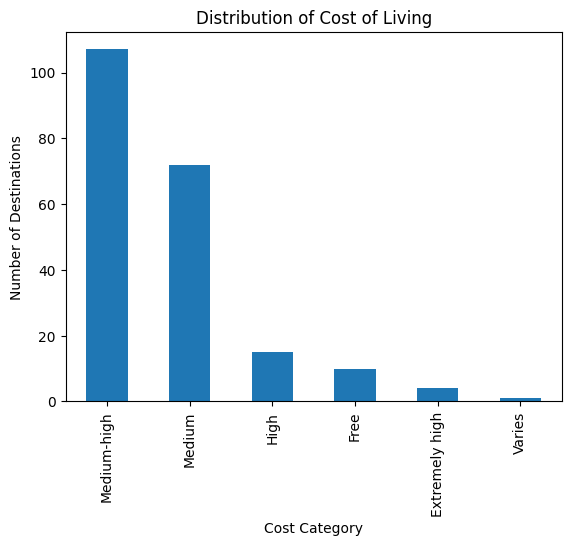

In [819]:
cost_counts = df['Cost of Living'].value_counts()
cost_counts.plot(kind='bar')
plt.title('Distribution of Cost of Living')
plt.xlabel('Cost Category')
plt.ylabel('Number of Destinations')
plt.show()

# Language Coverage

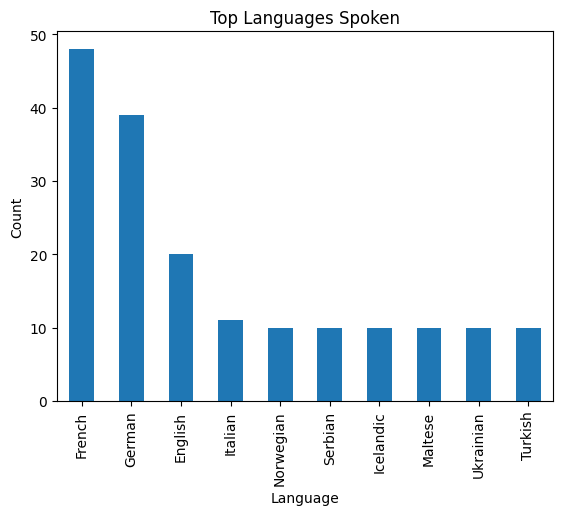

In [820]:
lang_counts = df['Language'].str.split(', ').explode().value_counts()
lang_counts.head(10).plot(kind='bar')
plt.title('Top Languages Spoken')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

# Extracting best time to visit

In [821]:
import re

def extract_seasons(text):
    if pd.isna(text):
        return "Unknown"
    text = text.lower()
    seasons = []
    if "spring" in text:
        seasons.append("Spring")
    if "summer" in text:
        seasons.append("Summer")
    if "fall" in text:
        seasons.append("Fall")
    if "winter" in text:
        seasons.append("Winter")
    if "year-round" in text:
        seasons.append("Year-round")
    return ", ".join(seasons) if seasons else "Unknown"

# Apply to column
df["Season"] = df["Best Time to Visit"].apply(extract_seasons)
print(df['Season'].unique())

['Spring, Fall' 'Summer' 'Summer, Winter' 'Year-round']


# One-hot encoding

Machine‑learning models (especially linear models, tree ensembles, neural nets, SVMs, etc.) can only work with numbers. Encoding turns your human‑readable categories into numeric vectors so that:

    - Algorithms can compute distances or weights (e.g. coefficient * feature).

    - You don’t accidentally impose an ordering (one‑hot means “red,” “green,” and “blue” are equidistant).

    - Ordinal info is preserved (a label encoder on “low/med/high” respects that order).

In [822]:
#multi label one-hot encoding for seasons
from sklearn.preprocessing import MultiLabelBinarizer


df["Season List"] = df["Season"].str.split(", ")
mlb = MultiLabelBinarizer()
season_dummies = pd.DataFrame(
    mlb.fit_transform(df["Season List"]),
    columns=mlb.classes_,
    index=df.index
)
df = pd.concat([df, season_dummies], axis=1)

print(df['Majority Religion'].unique())
religion_dummies = df['Majority Religion'].str.get_dummies(sep=', ')
df = df.join(religion_dummies)

print(df['Cost of Living'].unique()) #cost is ordinal, 
cost_map = {
    "Free":            0,
    "Medium":          1,
    "Medium-high":     2,
    "High":            3,
    "Extremely high":  4,
    "Varies":          5,
}
df['cost_enc'] = df['Cost of Living'].map(cost_map)

print(df['Language'].unique())
clean = (
    df['Language']
      # 1a. drop parentheses
      .str.replace(r'[()]', '', regex=True)

      # 1b. turn “and” (any case, any surrounding spaces) into a comma
      .str.replace(r'(?i)\s*\band\b\s*', ', ', regex=True)

      # 1c. turn any other delimiters you use into commas
      .str.replace(r'[;/]', ',', regex=True)

      # 1d. collapse multiple commas / spaces, strip ends
      .str.replace(r'\s*,\s*', ', ', regex=True)   # tidy commas
      .str.replace(r'\s+', ' ', regex=True)        # collapse whitespace
      .str.strip(' ,')                             # trim leftover ,/space
)
lan_dummies = clean.str.get_dummies(sep=', ')
df = df.join(lan_dummies)
print(clean.unique())

df.head()


['Roman Catholic' 'Protestant' 'Russian Orthodox'
 'Muslim, Russian Orthodox' 'Greek Orthodox' 'Muslim' 'Ukrainian Orthodox'
 'Christian (Anglican)' 'Christian (Presbyterian)' 'Serbian Orthodox']
['Medium-high' 'High' 'Medium' 'Free' 'Extremely high' 'Varies']
['Italian' 'Spanish' 'Spanish (and Basque)' 'French' 'French (and German)'
 'German' 'Dutch, French' 'Danish' 'French, Monegasque' 'Russian'
 'Russian, Tatar' 'Greek' 'Portuguese' 'Norwegian' 'Swedish'
 'German, French, Italian' 'French, German' 'German, French' 'Turkish'
 'Ukrainian' 'English' 'English, Scottish Gaelic'
 'Luxembourgish, French, German' 'Maltese, English' 'Icelandic' 'Serbian'
 'Serbian, Hungarian']
['Italian' 'Spanish' 'Spanish, Basque' 'French' 'French, German' 'German'
 'Dutch, French' 'Danish' 'French, Monegasque' 'Russian' 'Russian, Tatar'
 'Greek' 'Portuguese' 'Norwegian' 'Swedish' 'German, French, Italian'
 'German, French' 'Turkish' 'Ukrainian' 'English'
 'English, Scottish Gaelic' 'Luxembourgish, French,

,Destination,Region,Country,Category,Latitude,Longitude,Approximate Annual Tourists(million),Currency,Majority Religion,Famous Foods,...,Norwegian,Portuguese,Russian,Scottish Gaelic,Serbian,Spanish,Swedish,Tatar,Turkish,Ukrainian
0,Rome,Lazio,Italy,City,41.902782,12.496366,14.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,0,0,0,0,0,0,0
1,Florence,Tuscany,Italy,City,43.769581,11.255772,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,0,0,0,0,0,0,0
2,Venice,Veneto,Italy,City,45.435559,12.336196,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,0,0,0,0,0,0,0
3,Milan,Lombardy,Italy,City,45.464643,9.188540,7.0,Euro,Roman Catholic,"Risotto, Ossobuco, Panettone",...,0,0,0,0,0,0,0,0,0,0
4,Naples,Campania,Italy,City,40.851330,14.254720,5.0,Euro,Roman Catholic,"Pizza, Pasta, Cannoli",...,0,0,0,0,0,0,0,0,0,0


In [823]:
print(df['Safety'].unique())
risk_patterns = {
    'pickpockets': r'pickpocket',
    'crowds':      r'crowd',
    'wildlife':    r'bear',
    'conflict':    r'ongoing conflict',
    'generic_risk':r'potential risks?',
    'restricted':  r'restricted access'
}
def parse_risks(text):
    return {k: bool(re.search(pat, text, re.I)) for k, pat in risk_patterns.items()}

def severity(row):
    if row['restricted']:           return 3
    if row[['conflict']].any():     return 3
    if row[['pickpockets','crowds','wildlife','generic_risk']].any(): return 2
    return 1                        # plain “Generally safe”

parsed = df['Safety'].apply(parse_risks).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)
df['safety_severity'] = df.apply(severity, axis=1)
df.head()

['Generally safe, but watch out for pickpockets'
 'Generally safe, but be aware of pickpockets'
 'Generally safe, but be aware of crowds' 'Generally safe'
 'Generally safe, but watch for pickpockets'
 'Generally safe, but be aware of bears'
 'Generally safe, but be aware of ongoing conflict'
 'Generally safe, but be aware of potential risks' 'Restricted access']


,Destination,Region,Country,Category,Latitude,Longitude,Approximate Annual Tourists(million),Currency,Majority Religion,Famous Foods,...,Tatar,Turkish,Ukrainian,pickpockets,crowds,wildlife,conflict,generic_risk,restricted,safety_severity
0,Rome,Lazio,Italy,City,41.902782,12.496366,14.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,True,False,False,False,False,False,2
1,Florence,Tuscany,Italy,City,43.769581,11.255772,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,True,False,False,False,False,False,2
2,Venice,Veneto,Italy,City,45.435559,12.336196,10.0,Euro,Roman Catholic,"Pizza, Pasta, Gelato",...,0,0,0,True,False,False,False,False,False,2
3,Milan,Lombardy,Italy,City,45.464643,9.188540,7.0,Euro,Roman Catholic,"Risotto, Ossobuco, Panettone",...,0,0,0,True,False,False,False,False,False,2
4,Naples,Campania,Italy,City,40.851330,14.254720,5.0,Euro,Roman Catholic,"Pizza, Pasta, Cannoli",...,0,0,0,True,False,False,False,False,False,2


# Safety Severity Histogram

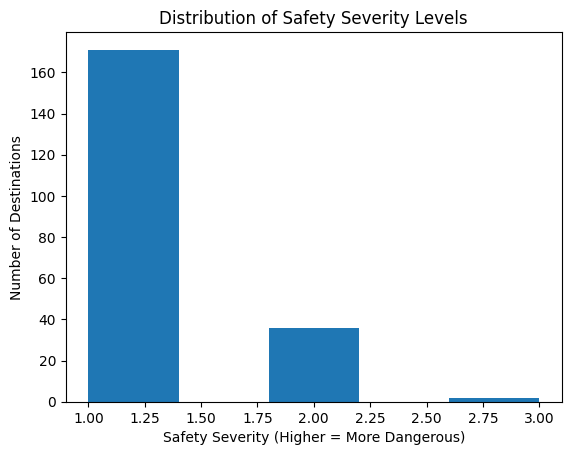

In [824]:
df['safety_severity'].plot(kind='hist', bins=5)
plt.title('Distribution of Safety Severity Levels')
plt.xlabel('Safety Severity (Higher = More Dangerous)')
plt.ylabel('Number of Destinations')
plt.show()

# Building SBERT (Sentence Embedding)
I am combining the destination name and cultural significance columns

In [825]:
# Choose / load an SBERT model
model_name = 'paraphrase-MiniLM-L6-v2'            # 384‑d, small & quick
model = SentenceTransformer(model_name)

#  Compose the text you’ll embed
text_col = (
    df['Destination'] + '. ' +                   # title helps queries like “Paris”
    df['Country'] + ". " +
    df['Broad Category'] + '. ' +
    df['Cultural Significance']
).tolist()

# Encode (batch‑encoded, GPU‑friendly, 1000 rows ≈ 2 s on CPU)
emb = model.encode(
    text_col,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True     # makes cosine == dot‑product
).astype('float32')               # faiss wants float32

# Build the ANN index.  For < 50 k rows a flat index is fine.
dim = emb.shape[1]                # 384
index = faiss.IndexFlatIP(dim)    # inner product ≈ cosine when vectors are unit‑norm
index.add(emb)                    # (N, dim)

# Persist to disk so you don’t re‑encode every run
faiss.write_index(index, "destinations.ip") # using the facebook AI similarity search to speed up the look-up
np.save("embeddings.npy", emb)

Batches: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


# Applying post-filters
I want hard filters(safety was applied above) that are deal breakers for users, and buckets to influence the ranking, not removal.

In [826]:
def apply_filters(hits: pd.DataFrame, prefs: dict) -> pd.DataFrame: #hard-filters
    # safety threshold
    if 'safety_min' in prefs:
        hits = hits[hits['safety_severity'] <= prefs['safety_min']]
   
    return hits

def apply_penalties(hits: pd.DataFrame, prefs: dict, alpha: float = 0.8) -> pd.DataFrame: #soft filters
    penalties = np.zeros(len(hits))
    # cost difference penalty
    if 'cost' in prefs:
        target = cost_map.get(prefs['cost'], df['cost_enc'].median())
        penalties += np.abs(hits['cost_enc'] - target)
    # season softly penalize non-matches
    if 'seasons' in prefs:
        pattern = '|'.join(prefs['seasons'])
        penalties += (~hits['Best Time to Visit'].str.contains(pattern, case=False, na=False)).astype(int)
    # final composite score
    hits['score'] = alpha * hits['cos_sim'] - (1 - alpha) * penalties
    return hits

# Testing the SBERT

In [827]:
index = faiss.read_index("destinations.ip")
def search(query: str,
           prefs: dict = None,
           k: int = 10,
           overfetch: int = 5) -> pd.DataFrame:
    # 4.1 — encode & over-fetch via SBERT
    q_vec = model.encode(query, normalize_embeddings=True).astype('float32').reshape(1, -1)
    D, I = index.search(q_vec, k * overfetch)
    hits = df.iloc[I[0]].copy()
    hits['cos_sim'] = D[0]

    # 4.2 — hard filters (if prefs given)
    if prefs:
        hits = apply_filters(hits, prefs)

    # 4.3 — soft rerank (if prefs given), else fallback to cos_sim
    if prefs:
        hits = apply_penalties(hits, prefs)
    else:
        hits['score'] = hits['cos_sim']

    # 4.4 — return top-k by composite score
    return hits.sort_values('score', ascending=False).head(k)

prefs = {
    'seasons':    ['Summer', 'Spring'],
    'safety_min': 3,
    'cost': 'Medium'
    
}
results = search("I like beaches and taking photos", prefs = prefs, k = 5)
print(results[['Destination', 'Country', 'cos_sim', 'score']])

        Destination  Country   cos_sim     score
183  St. Paul's Bay    Malta  0.343350  0.274680
48           Ostend  Belgium  0.334377  0.267501
196      Westfjords  Iceland  0.329920  0.263936
15           Malaga    Spain  0.324944  0.259955
95            Corfu   Greece  0.323388  0.258710


# Visualize SBERT 

In [ ]:
embeddings = np.load('embeddings.npy')
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Build DataFrame



from sklearn.cluster import KMeans

# Load your SBERT embeddings

# Choose number of clusters (try 5–10)
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add results to your DataFrame
df['Cluster'] = clusters
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}")
    print(df[df['Cluster'] == i]['Destination'].head(10))
embeddings_2d = PCA(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(10,7))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("SBERT Embeddings Clustered by KMeans")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster ID')
plt.show()


Cluster 0
6             Amalfi Coast
8                Lake Como
17                   Ibiza
18                 Majorca
21                    Nice
48                  Ostend
73    Oceanographic Museum
74         Japanese Garden
75    Saint-Martin Gardens
76           Exotic Garden
Name: Destination, dtype: object

Cluster 1
27          Mont Saint-Michel
29                French Alps
32                  Innsbruck
36              Wachau Valley
38               Vienna Woods
39                Bad Gastein
58    Aarhus Botanical Garden
69               Black Forest
85                Lake Baikal
86        Kamchatka Peninsula
Name: Destination, dtype: object

Cluster 2
0             Rome
1         Florence
2           Venice
3            Milan
4           Naples
5     Cinque Terre
7             Pisa
9           Verona
10       Barcelona
11          Madrid
Name: Destination, dtype: object

Cluster 3
53          Legoland Billund
59            Tivoli Gardens
68     Neuschwanstein Castle
80        

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Combining embedding (needs a lot of tuning, can work on it after submission)
Keep SBERT and categorical data separate, then I will concatenate them.

In [829]:
# Build categorical block
cat_cols = (
    list(season_dummies.columns) +
    list(religion_dummies.columns) +
    ['cost_enc'] +
    list(lan_dummies.columns) +
    list(risk_patterns.keys()) +     # 5 binary risk flags
    ['safety_severity']              # 1 numeric
)
assert len(cat_cols) == 45  
cat_mat = df[cat_cols].values       # keeps column order!

scaler = StandardScaler()
cat_scaled = scaler.fit_transform(cat_mat)

text_vecs = np.load("embeddings.npy").astype('float32')   # (N,384)
combined = np.hstack([text_vecs, cat_scaled.astype('float32')])
faiss.normalize_L2(combined)

dim    = combined.shape[1]
index  = faiss.IndexFlatIP(dim)   # create the index object
index.add(combined)               # add returns None  ← keep it separate
faiss.write_index(index, "destinations_combined.ip")

np.save("combined_embeddings.npy", combined)
joblib.dump(scaler, "cat_scaler.pkl")

scaler = joblib.load("cat_scaler.pkl")
index  = faiss.read_index("destinations_combined.ip")
model  = SentenceTransformer("paraphrase-MiniLM-L6-v2")

def make_cat_vec(pref:dict)->np.ndarray:
    """Return a 1-D numpy array of length 45 matching cat_cols."""
    v = np.zeros(len(cat_cols), dtype=float)

    # iterate through cat_cols so order is guaranteed
    for i, col in enumerate(cat_cols):
        if col in season_dummies.columns and 'seasons' in pref:
            if col in pref['seasons']: v[i] = 1

        elif col in religion_dummies.columns and 'religions' in pref:
            if col in pref['religions']: v[i] = 1

        elif col in lan_dummies.columns and 'languages' in pref:
            if col in pref['languages']: v[i] = 1

        elif col == 'cost_enc' and 'cost' in pref:
            v[i] = cost_map.get(pref['cost'], 5)

        elif col in risk_patterns and 'risk_flags' in pref:
            if col in pref['risk_flags']: v[i] = 1

        elif col == 'safety_severity' and 'safety_min' in pref:
            v[i] = pref['safety_min']

    return v



In [830]:
CSV   = "destinations_cleaned.csv"
IDX_S = "destinations.ip"           # pure-SBERT Faiss index
IDX_H = "destinations_combined.ip"  # hybrid Faiss index
SCALER= "cat_scaler.pkl"  
model       = SentenceTransformer("paraphrase-MiniLM-L6-v2")
idx_sbert   = faiss.read_index(IDX_S)
idx_hybrid  = faiss.read_index(IDX_H)
scaler      = joblib.load(SCALER)

sbert_dim   = idx_sbert.d           # 384 by default
cat_dim     = index.d - model.get_sentence_embedding_dimension()

def sbert_search(query:str, k:int=10):
    vec = model.encode(query, normalize_embeddings=True).astype('float32').reshape(1,-1)
    _, I = idx_sbert.search(vec, k)
    return df.iloc[I[0]]

def hybrid_search(q, prefs=None, k=10):
    q_text = model.encode(q, normalize_embeddings=True)
    if prefs:
        q_cat  = scaler.transform([make_cat_vec(prefs)])[0]
    else:
        q_cat  = np.zeros(index.d - q_text.shape[0])
    q_vec = np.hstack([q_text, q_cat]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(q_vec)    
    _, I    = idx_hybrid.search(q_vec, k)
    
    
    return df.iloc[I[0]]


eval_pairs = [
    ("snowy wildlife photography spots",  df[df["Destination"].str.contains("Lapland", case=False, na=False)].index[0]),
    ("ancient roman ruins near coast",    df[df["Destination"].str.contains("Rome",       case=False, na=False)].index[0]),
    ("northern lights viewing winter",    df[df["Destination"].str.contains("Pisa", case=False, na=False)].index[0]),
]

def hit_rate_at_k(search_fn, pairs, k=10, **kwargs):
    hits = 0
    for q, true_idx in pairs:
        res = search_fn(q, k=k, **kwargs) if kwargs else search_fn(q, k=k)
        if true_idx in res:
            hits += 1
    return hits / len(pairs)

preferences = {
    'seasons': 'summer',
    'cost': 'free'
}
pure_score   = hit_rate_at_k(lambda q, k: sbert_search(q, k), eval_pairs, k=10)
hybrid_score = hit_rate_at_k(lambda q, k: hybrid_search(q, prefs=None, k=k),
                             eval_pairs, k=10)

print(f"Hit@10  pure SBERT : {pure_score:.2f}")
print(f"Hit@10  hybrid     : {hybrid_score:.2f}")
print(sbert_search("best country side destinations for the summer", k = 5)[["Destination"]])
print(hybrid_search("best country side destinations for the summer", prefs = None, k = 5)[["Destination"]])

Hit@10  pure SBERT : 0.00
Hit@10  hybrid     : 0.00
                  Destination
152                    Odessa
92                    Mykonos
21                       Nice
153  Chernobyl Exclusion Zone
102                   Algarve
     Destination
28  Loire Valley
21          Nice
45        Dinant
49         Namur
47           Spa


In [831]:
q_text = model.encode("snowy wildlife photography spots", normalize_embeddings=True)
q_cat  = scaler.transform([make_cat_vec({"seasons":["Winter"],"safety_min":2})])[0]
print("‖text‖ =", np.linalg.norm(q_text), " ‖cat‖ =", np.linalg.norm(q_cat))

# 2️⃣ look at an item vector
row =  df[df["Destination"].str.contains("Lapland", case=False)].index[0]
print("Item ‖text‖ =", np.linalg.norm(text_vecs[row]),
      "Item ‖cat‖  =", np.linalg.norm(cat_scaled[row]))

# 3️⃣ confirm dimensions
print("index.d =", idx_hybrid.d, " query dim =", q_text.size + q_cat.size)



‖text‖ = 1.0  ‖cat‖ = 6.960964689217148
Item ‖text‖ = 1.0 Item ‖cat‖  = 8.323359305028253
index.d = 429  query dim = 429
